## Improving Randomized Search Sequentially

[Hyperopt](http://hyperopt.github.io/hyperopt/) has a search algorithm that they call **Simulated annealing** that starts with a randomized search, and then follows up by scanning hyperparameter values in the most promising areas, instead of completely at random.

In this notebook, we'll compare a randomized search with the simulated annealing algorithm in terms of time and performance.

We'll optimise the parameters of a Gradient Boosting Machine of the [xgboost package](https://xgboost.readthedocs.io/en/latest/python/python_intro.html).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

import xgboost as xgb

from hyperopt import hp, anneal, rand, fmin, Trials

# hp: define the hyperparameter space
# rand: random search
# anneal: simulated annealing
# fmin: optimization function
# Trials: to evaluate the different searched hyperparameters

In [2]:
# load dataset

X, y = load_breast_cancer(return_X_y=True, as_frame=True)
y = y.map({0:1, 1:0})

X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# the target:
# percentage of benign (0) and malign tumors (1)

y.value_counts(normalize=True)

target
0    0.627417
1    0.372583
Name: proportion, dtype: float64

In [4]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((398, 30), (171, 30))

## Define the Hyperparameter Space

- [Hyperopt search space](http://hyperopt.github.io/hyperopt/getting-started/search_spaces/)

- [xgb.XGBClassifier hyperparameters](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier)

- [xgb general parameters](https://xgboost.readthedocs.io/en/latest/parameter.html)

In [5]:
# determine the hyperparameter space

param_grid = {
    'n_estimators': hp.quniform('n_estimators', 200, 2500, 100),
    'max_depth': hp.uniform('max_depth', 1, 10),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.99),
    'booster': hp.choice('booster', ['gbtree', 'dart']),
    'gamma': hp.quniform('gamma', 0.01, 10, 0.1),
    'subsample': hp.uniform('subsample', 0.50, 0.90),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.50, 0.99),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.50, 0.99),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.50, 0.99),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
}

## Define the objective function

This is the hyperparameter response space, the function we want to minimize.

In [6]:
# the objective function takes the hyperparameter space
# as input

def objective(params):

    # we need a dictionary to indicate which value from the space
    # to attribute to each value of the hyperparameter in the xgb
    params_dict = {
        'n_estimators': int(params['n_estimators']), # important int, as it takes integers only
        'max_depth': int(params['max_depth']), # important int, as it takes integers only
        'learning_rate': params['learning_rate'],
        'booster': params['booster'],
        'gamma': params['gamma'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'colsample_bylevel': params['colsample_bylevel'],
        'colsample_bynode': params['colsample_bynode'],
        'random_state': 1000,
    }

    # with ** we pass the items in the dictionary as parameters
    # to the xgb
    gbm = xgb.XGBClassifier(**params_dict)

    # train with cv
    score = cross_val_score(gbm, X_train, y_train,
                            scoring='accuracy', cv=5, n_jobs=4).mean()

    # to minimize, we negate the score
    return -score

## Randomized Search

[fmin](http://hyperopt.github.io/hyperopt/getting-started/minimizing_functions/)

In [7]:
trials_random = Trials()

In [8]:
random_search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=30,
    rstate=np.random.default_rng(42),
    algo=rand.suggest,  # randomized search
    trials=trials_random
)

100%|████████████████████████████████████████████| 30/30 [2:49:02<00:00, 338.09s/trial, best loss: -0.9724683544303797]


In [9]:
# best hyperparameters

random_search

{'booster': 0,
 'colsample_bylevel': 0.6675175922144583,
 'colsample_bynode': 0.502689136294866,
 'colsample_bytree': 0.9335921673214591,
 'gamma': 0.8,
 'learning_rate': 0.5628067599908174,
 'max_depth': 1.5394257017326047,
 'n_estimators': 2200.0,
 'reg_lambda': 12.556734081251594,
 'subsample': 0.6201685419162033}

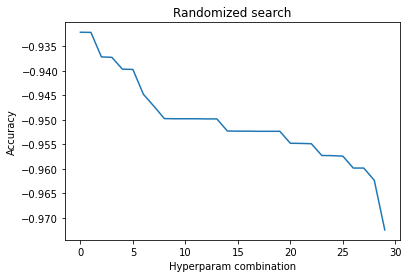

In [10]:
results = pd.concat([
    pd.DataFrame(trials_random.vals),
    pd.DataFrame(trials_random.results)],
    axis=1,
).sort_values(by='loss', ascending=False).reset_index(drop=True)

results['loss'].plot()
plt.ylabel('Accuracy')
plt.xlabel('Hyperparam combination')
plt.title("Randomized search")
plt.show()

In [11]:
pd.DataFrame(trials_random.results)['loss'].min()

-0.9724683544303797

## Simulated annealing

In [14]:
trials_anneal = Trials()

anneal_search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=30,
    rstate=np.random.default_rng(42),
    algo=anneal.suggest,  # simulated annealing
    trials=trials_anneal,
)

100%|██████████████████████████████████████████| 30/30 [20:38:22<00:00, 2476.75s/trial, best loss: -0.9623417721518986]


In [15]:
# best hyperparameters

anneal_search

{'booster': 1,
 'colsample_bylevel': 0.7522339251637544,
 'colsample_bynode': 0.7360389699007959,
 'colsample_bytree': 0.739471258309178,
 'gamma': 2.8000000000000003,
 'learning_rate': 0.7179957489030868,
 'max_depth': 9.373798381868017,
 'n_estimators': 2200.0,
 'reg_lambda': 15.226514173285173,
 'subsample': 0.7230373283845886}

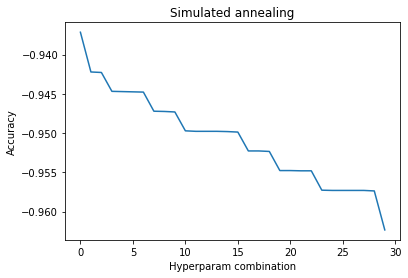

In [16]:
results = pd.concat([
    pd.DataFrame(trials_anneal.vals),
    pd.DataFrame(trials_anneal.results)],
    axis=1,
).sort_values(by='loss', ascending=False).reset_index(drop=True)

results['loss'].plot()
plt.ylabel('Accuracy')
plt.xlabel('Hyperparam combination')
plt.title("Simulated annealing")
plt.show()

In [17]:
pd.DataFrame(trials_anneal.results)['loss'].min()

-0.9623417721518986

Based on these results, which are by no means conclusive, simulated annealing did not outperform randomized search.